# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp
import random
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torchvision

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 16
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        # Compute the focal loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probability of true class
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()
        return focal_loss

In [9]:
##################### Write your answer here ##################
# Define the loss function
criterion = FocalLoss(gamma=2, alpha=0.25)
###############################################################

In [10]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ################## 
    output = model(image)
    loss = criterion(output, target)
    
    ###############################################################

    return output, loss

In [11]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    #output = model(image)
    output = model(image)
    loss = criterion(output, target)
    #loss_fn = nn.CrossEntropyLoss()
    #loss_fn =ce_loss(output, target)
    #loss_fn = nn.L1Loss()
    #loss_fn =focal_loss_gamma_0_5(output, target)
    #loss_fn =focal_loss_gamma_2(output, target)
    #loss = loss_fn(output, target)  
    ###############################################################

    return output, loss

In [12]:
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # Define your model, optimizer, and other necessary components
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    NUM_CLASS = 10
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    SAVE_DIR = './log'
    transform_cifar10_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_cifar10_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                             download=True, transform=transform_cifar10_train)

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                   shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                            download=True, transform=transform_cifar10_test)

    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                  shuffle=False, num_workers=2)


    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)

### Model Training

In [13]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
            
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # Define your model, optimizer, and loss function
    model = ConvNet()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    loss_fn = MAELoss()

    results = []

    for epoch in range(NUM_EPOCHS):
        # Your training code here

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test...')
            model.eval()

            # Your testing code here

            # Calculate testing loss and accuracy
            testing_loss.append(test_loss)
            testing_acc.append(test_acc)

        # Your code to save the model in the last epoch

    return model

# Call train_and_evaluate function with your desired hyperparameters
#result = train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL)

# Append the result to the results list
#results.append(result)








Epoch: 1/30 Train Loss: 0.0228 Acc: 0.2616
Begin test......
Test Loss: 0.0233 Acc: 0.2725
Epoch: 2/30 Train Loss: 0.0220 Acc: 0.2817
Begin test......
Test Loss: 0.0204 Acc: 0.3037
Epoch: 3/30 Train Loss: 0.0220 Acc: 0.2785
Begin test......
Test Loss: 0.0205 Acc: 0.2986
Epoch: 4/30 Train Loss: 0.0221 Acc: 0.2780
Begin test......
Test Loss: 0.0202 Acc: 0.3288
Epoch: 5/30 Train Loss: 0.0218 Acc: 0.2836
Begin test......
Test Loss: 0.0208 Acc: 0.3011
Epoch: 6/30 Train Loss: 0.0207 Acc: 0.3085
Begin test......
Test Loss: 0.0197 Acc: 0.3212
Epoch: 7/30 Train Loss: 0.0203 Acc: 0.3166
Begin test......
Test Loss: 0.0189 Acc: 0.3573
Epoch: 8/30 Train Loss: 0.0201 Acc: 0.3250
Begin test......
Test Loss: 0.0192 Acc: 0.3398
Epoch: 9/30 Train Loss: 0.0201 Acc: 0.3246
Begin test......
Test Loss: 0.0194 Acc: 0.3342
Epoch: 10/30 Train Loss: 0.0200 Acc: 0.3244
Begin test......
Test Loss: 0.0189 Acc: 0.3534
Epoch: 11/30 Train Loss: 0.0192 Acc: 0.3489
Begin test......
Test Loss: 0.0179 Acc: 0.3856
Epoch: 1

In [14]:
print(training_loss, training_acc, testing_loss, testing_acc)

[0.022810655694305897, 0.021975394102334976, 0.021986088449954987, 0.022065309299528598, 0.021752944081425668, 0.020695241120159625, 0.020301029237508775, 0.020124019401073456, 0.02010014475017786, 0.020029142828285693, 0.019198041871488096, 0.019055796750187873, 0.018880323963463307, 0.018806606690883635, 0.018765231656432152, 0.018244783155918123, 0.018144927747845648, 0.018049067487418653, 0.017956874883770943, 0.017860967369079588, 0.017484441711604595, 0.017371509951651095, 0.017273539490401744, 0.01722072092756629, 0.01718489989116788, 0.01690555002003908, 0.01676330245614052, 0.01680371741488576, 0.016695727519094945, 0.016595220867544412] [array(0.26156), array(0.28172), array(0.2785), array(0.27796), array(0.2836), array(0.3085), array(0.31658), array(0.32502), array(0.32464), array(0.32444), array(0.34894), array(0.3512), array(0.35526), array(0.3603), array(0.36046), array(0.37434), array(0.37836), array(0.37872), array(0.38132), array(0.38514), array(0.39578), array(0.39434

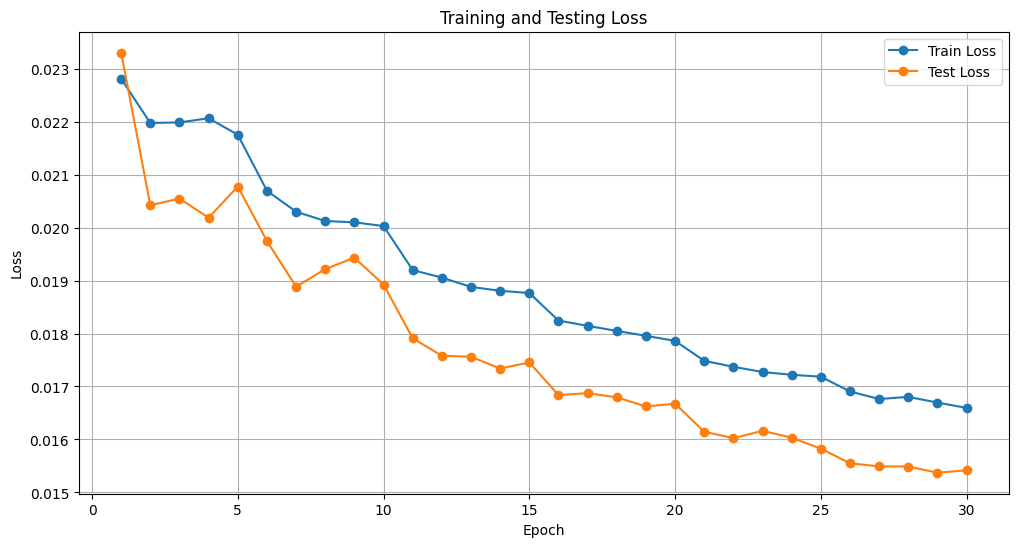

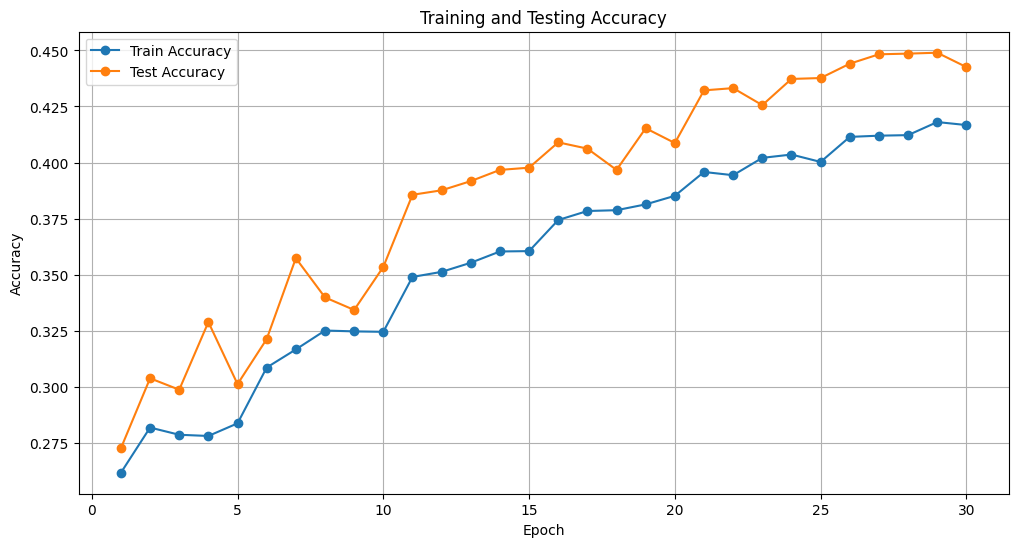

In [15]:
process_data = {
        'Epoch': list(range(1, NUM_EPOCHS + 1)),
        'Train Loss': training_loss,
        'Train Accuracy': training_acc,
        'Test Loss': testing_loss,
        'Test Accuracy': testing_acc,
}
plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Loss'], label='Train Loss', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Loss'], label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [16]:
def train_batch(model, image, target):
    # Perform one training batch iteration.
    output = model(image)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, target)
    return output, loss


def test_batch(model, image, target):
    # Perform one testing batch iteration.
    output = model(image)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, target)
    return output, loss


def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # Define your model, optimizer, and other necessary components
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    NUM_CLASS = 10
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    SAVE_DIR = './log'
    transform_cifar10_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_cifar10_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                             download=True, transform=transform_cifar10_train)

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                   shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                            download=True, transform=transform_cifar10_test)

    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                  shuffle=False, num_workers=2)
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model = models.resnet18(weights='imagenet')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()
        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)

            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test...')
            model.eval()
            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

In [17]:
inputs, classes = next(iter(test_dataloader))
inputs = inputs.to(device)
input = inputs[0]
input = input.to(device)

In [18]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
with torch.no_grad():
        model.eval()
        output = model(input.unsqueeze(0))
        probabilities = torch.softmax(output, dim=1)
        predict_label = torch.argmax(probabilities, dim=1).item()
#probabilities = torch.softmax(output, dim=1)
#predict_label = torch.argmax(probabilities, dim=1)

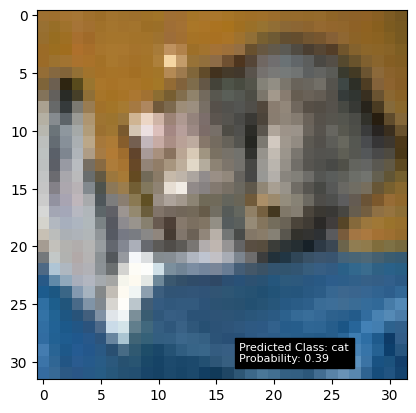

Print probabilities for each class:
airplane: 0.0061
automobile: 0.0112
bird: 0.0659
cat: 0.3875
deer: 0.0815
dog: 0.2495
frog: 0.0897
horse: 0.0918
ship: 0.0052
truck: 0.0115


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
predicted_class = class_names[predict_label]
predicted_probability = probabilities[0, predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
image = (image * np.array([0.2023, 0.1994, 0.2010])) + np.array([0.4914, 0.4822, 0.4465])
image = np.clip(image, 0, 1)
image = Image.fromarray((image * 255).astype(np.uint8))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0,i].item():.4f}')
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # 在这里定义 train_and_evaluate 函数，包含你的训练和评估逻辑
    # 返回训练好的模型
    model = models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    
    return model
if __name__ == '__main__':

    learning_rate = 0.1
    momentum = 0.5
    step = 5
    gamma = 0.9
    EVAL_INTERVAL = 30
    results = []

    SEED = 1
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    result = train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL)